<a href="https://colab.research.google.com/github/HenryLiu0405/Stock-Price-Prediction/blob/main/Stock_Price_Predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#open to browse the file
from google.colab import files
uploaded_1 = files.upload()
uploaded_2 = files.upload()

Saving MSFT.csv to MSFT.csv


Saving Tesla.csv to Tesla.csv


In [3]:
#content
import pandas as pd # Import the pandas library
Stock1 = 'MSFT.csv'
Stock2 = 'Tesla.csv'
df1 = pd.read_csv(Stock1)  #utf-8
df2 = pd.read_csv(Stock2)

Clean and prepare data

In [5]:
# clean function
def preprocess(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Close'] = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
    df['Open'] = df['Open'].replace('[\$,]', '', regex=True).astype(float)
    df['High'] = df['High'].replace('[\$,]', '', regex=True).astype(float)
    df['Low'] = df['Low'].replace('[\$,]', '', regex=True).astype(float)
    df['Volume'] = df['Volume'].replace('[,]', '', regex=True).astype(float)
    return df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

In [6]:
# clean data for MSFT and Tesla
df1_clean = preprocess(df1)
df2_clean = preprocess(df2)

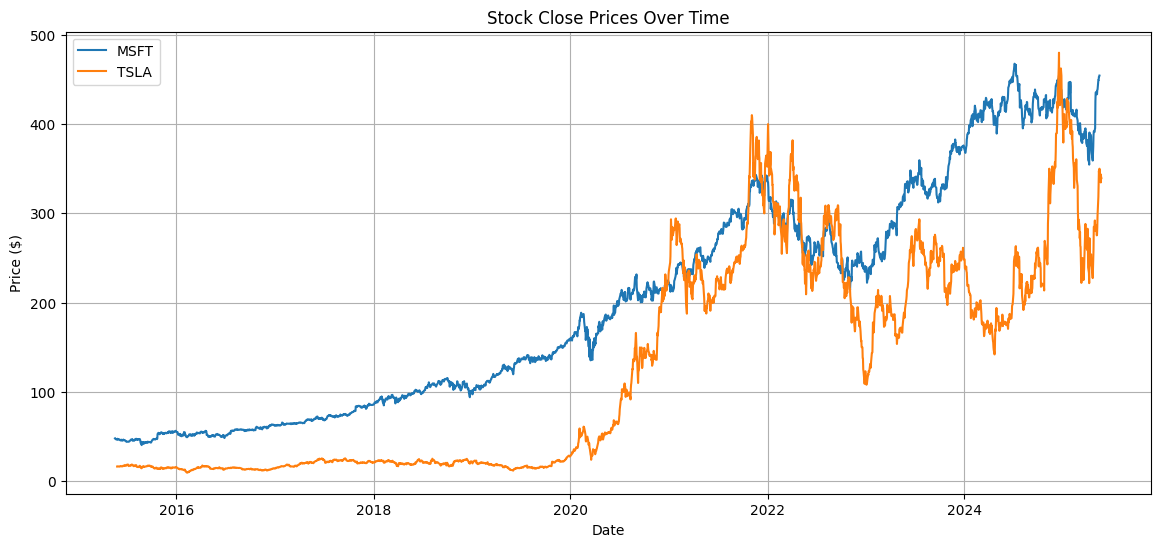

In [7]:
# visualize
plt.figure(figsize=(14,6))
plt.plot(df1_clean['Date'], df1_clean['Close'], label='MSFT')
plt.plot(df2_clean['Date'], df2_clean['Close'], label='TSLA')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


Train Prophet Model

In [8]:
!pip install prophet
from prophet import Prophet

In [9]:
prophet_df1 = df1_clean[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df2 = df2_clean[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [10]:
# Fit Prophet models
model1 = Prophet()
model1.fit(prophet_df1)

model2 = Prophet()
model2.fit(prophet_df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9e895ru/7p59qdbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9e895ru/68bab9ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26872', 'data', 'file=/tmp/tmps9e895ru/7p59qdbe.json', 'init=/tmp/tmps9e895ru/68bab9ci.json', 'output', 'file=/tmp/tmps9e895ru/prophet_model6q8tohvt/prophet_model-20250527011019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps9

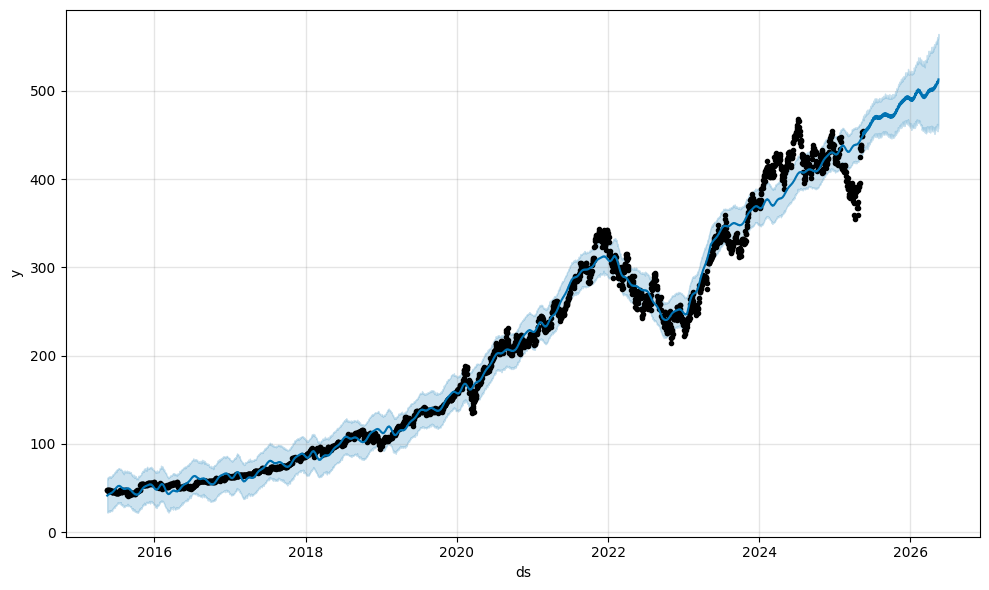

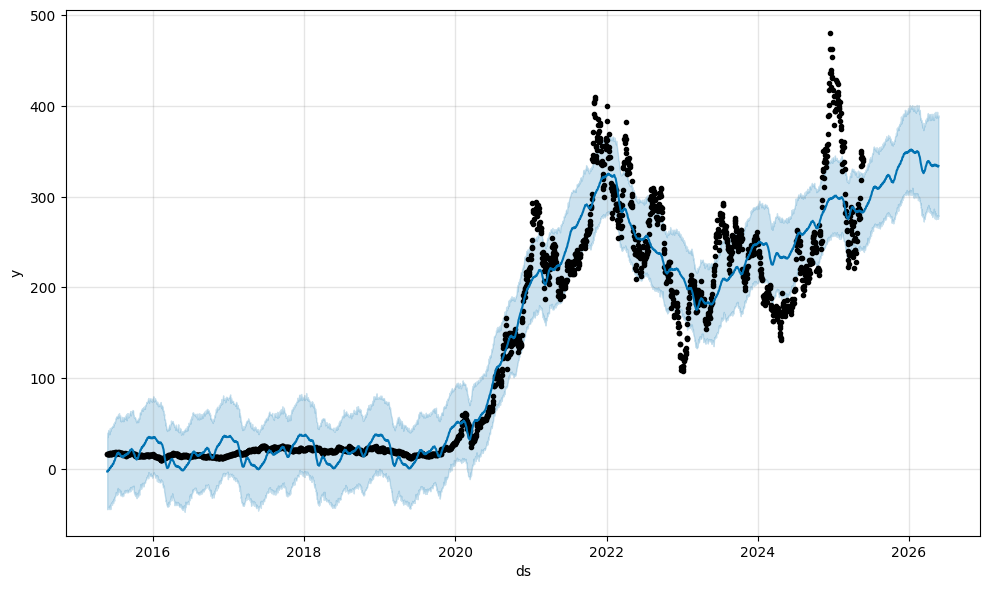

In [16]:
# Forecast 1 year into the future
future1 = model1.make_future_dataframe(periods=365)
forecast1 = model1.predict(future1)

future2 = model2.make_future_dataframe(periods=365)
forecast2 = model2.predict(future2)

# Plot forecasts
model1.plot(forecast1);
model2.plot(forecast2);

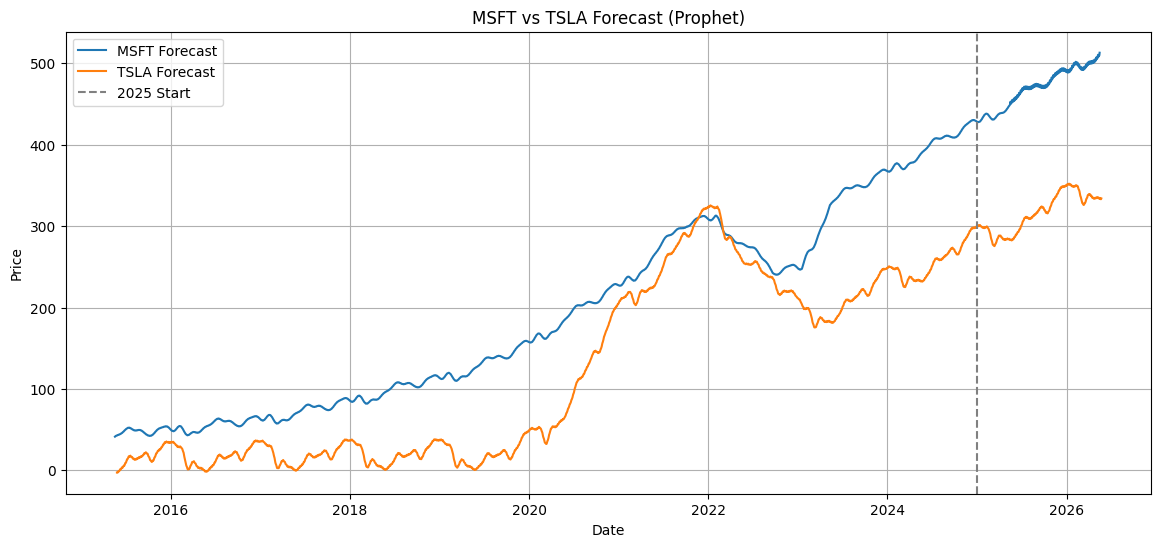

In [17]:
# Plot both forecasts together
plt.figure(figsize=(14, 6))
plt.plot(forecast1['ds'], forecast1['yhat'], label='MSFT Forecast')
plt.plot(forecast2['ds'], forecast2['yhat'], label='TSLA Forecast')
plt.axvline(pd.to_datetime('2025-01-01'), color='gray', linestyle='--', label='2025 Start')
plt.title("MSFT vs TSLA Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Compare End of 2025 Predictions
end_2025_msft = forecast1[forecast1['ds'] == forecast1['ds'].max()]['yhat'].values[0]
end_2025_tsla = forecast2[forecast2['ds'] == forecast2['ds'].max()]['yhat'].values[0]

print(f"MSFT forecasted price at end of 2025: ${end_2025_msft:.2f}")
print(f"TSLA forecasted price at end of 2025: ${end_2025_tsla:.2f}")

if end_2025_msft > end_2025_tsla:
    print("\n Recommendation: Invest in MSFT — higher predicted value by end of 2025.")
else:
    print("\n Recommendation: Invest in TSLA — higher predicted value by end of 2025.")

MSFT forecasted price at end of 2025: $512.96
TSLA forecasted price at end of 2025: $333.99

✅ Recommendation: Invest in MSFT — higher predicted value by end of 2025.


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(actual_df, forecast_df):
    merged = pd.merge(actual_df, forecast_df[['ds', 'yhat']], on='ds')
    y_true = merged['y']
    y_pred = merged['yhat']
    print("\nModel Evaluation:")
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

evaluate_model(prophet_df1, forecast1)
evaluate_model(prophet_df2, forecast2)



Model Evaluation:
MSE: 226.24495489773145
MAE: 9.814609365472148
R²: 0.9857958765164367

Model Evaluation:
MSE: 1055.9228410731469
MAE: 22.30236577370153
R²: 0.9255557526171669
